# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. 

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.



## Импортируем библиотеки

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Модели

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split, KFold


from sklearn.metrics import f1_score, roc_auc_score, mean_squared_error, mean_absolute_error, make_scorer


import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams, rcParamsDefault
from sklearn.model_selection import GridSearchCV
import numpy as np
import itertools 
import math
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from functools import reduce   
from scipy import stats as st

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn import linear_model
from feature_engine.selection import DropCorrelatedFeatures, DropDuplicateFeatures

from sklearn.pipeline import Pipeline, FeatureUnion, FunctionTransformer
from imblearn.pipeline import make_pipeline
from numpy.random import RandomState
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import LabelEncoder

import re
import nltk 
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
import string 
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer
import sys

import torch
import transformers as ppb # pytorch transformers

[nltk_data] Downloading package wordnet to /home/benji/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/benji/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/benji/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Изучение данных

In [2]:
try:
    data = pd.read_csv('/datasets/toxic_comments.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [3]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [5]:
data.describe()

,Unnamed: 0,toxic
count,159292.000000,159292.000000
mean,79725.697242,0.101612
std,46028.837471,0.302139
min,0.000000,0.000000
25%,39872.750000,0.000000
50%,79721.500000,0.000000
75%,119573.250000,0.000000
max,159450.000000,1.000000


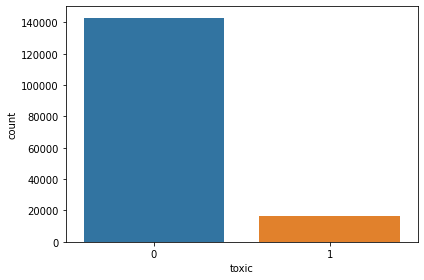

In [6]:
sns.countplot(x = data['toxic'])
plt.tight_layout()

In [7]:
data

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
...,...,...,...
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0


**Вывод**
Для выполнения проекта необходимо:
- Предобработать данные
- Обучить модели

## Подготовка данных

### Удалим лишнюю колонку

In [8]:
data = data.drop(['Unnamed: 0'], axis=1)

In [9]:
data_bert = data.copy()
data_bert.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


### Удалим пунктуацию

In [10]:
def remove_punctuation(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

In [11]:
data['lemm_text'] = data['text'].apply(lambda x: remove_punctuation(x))

In [12]:
data.head()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,Explanation\nWhy the edits made under my usern...
1,D'aww! He matches this background colour I'm s...,0,Daww He matches this background colour Im seem...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man Im really not trying to edit war Its j...
3,"""\nMore\nI can't make any real suggestions on ...",0,\nMore\nI cant make any real suggestions on im...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...


### Токенизируем

In [13]:
def tokenise(text):
    text = re.split('\W+', text)
    return text


In [14]:
 data['lemm_text'] = data['lemm_text'].apply(lambda x: tokenise(x.lower()))

In [15]:
data.head()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,"[explanation, why, the, edits, made, under, my..."
1,D'aww! He matches this background colour I'm s...,0,"[daww, he, matches, this, background, colour, ..."
2,"Hey man, I'm really not trying to edit war. It...",0,"[hey, man, im, really, not, trying, to, edit, ..."
3,"""\nMore\nI can't make any real suggestions on ...",0,"[, more, i, cant, make, any, real, suggestions..."
4,"You, sir, are my hero. Any chance you remember...",0,"[you, sir, are, my, hero, any, chance, you, re..."


### Удалим стоп слова

In [16]:
stopwords = nltk.corpus.stopwords.words('english')  

In [17]:
def remove_stopwords(text):
    text = [word for word in text if word not in stopwords]
    return text

In [18]:
data['lemm_text'] = data['lemm_text'].apply(lambda x: remove_stopwords(x))

In [19]:
data.head()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,"[explanation, edits, made, username, hardcore,..."
1,D'aww! He matches this background colour I'm s...,0,"[daww, matches, background, colour, im, seemin..."
2,"Hey man, I'm really not trying to edit war. It...",0,"[hey, man, im, really, trying, edit, war, guy,..."
3,"""\nMore\nI can't make any real suggestions on ...",0,"[, cant, make, real, suggestions, improvement,..."
4,"You, sir, are my hero. Any chance you remember...",0,"[sir, hero, chance, remember, page, thats]"


### Леммизируем текст

In [20]:
lemmatizer = nltk.WordNetLemmatizer()

In [21]:
def lemmatise_this(text):
    text = [lemmatizer.lemmatize(word) for word in text]
    return text

In [22]:
data['lemm_text'] = data['lemm_text'].apply(lambda x: lemmatise_this(x))

In [23]:
data.head()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,"[explanation, edits, made, username, hardcore,..."
1,D'aww! He matches this background colour I'm s...,0,"[daww, match, background, colour, im, seemingl..."
2,"Hey man, I'm really not trying to edit war. It...",0,"[hey, man, im, really, trying, edit, war, guy,..."
3,"""\nMore\nI can't make any real suggestions on ...",0,"[, cant, make, real, suggestion, improvement, ..."
4,"You, sir, are my hero. Any chance you remember...",0,"[sir, hero, chance, remember, page, thats]"


### Удалим пропуски

In [24]:
def remove_empty(text):
    text = list(filter(None, text))
    return text

data['lemm_text'] = data['lemm_text'].apply(lambda x: remove_empty(x))
data.head()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,"[explanation, edits, made, username, hardcore,..."
1,D'aww! He matches this background colour I'm s...,0,"[daww, match, background, colour, im, seemingl..."
2,"Hey man, I'm really not trying to edit war. It...",0,"[hey, man, im, really, trying, edit, war, guy,..."
3,"""\nMore\nI can't make any real suggestions on ...",0,"[cant, make, real, suggestion, improvement, wo..."
4,"You, sir, are my hero. Any chance you remember...",0,"[sir, hero, chance, remember, page, thats]"


In [25]:
data.sample(10)# Случайный семпл на всякий случай.

,text,toxic,lemm_text
66754,"""\nI havn't yet personally deleted the toys se...",0,"[havnt, yet, personally, deleted, toy, section..."
31123,White racist white girl \n\nWhat makes you thi...,1,"[white, racist, white, girl, make, think, talk..."
67447,I am getting seriously pissed off. Dont revert...,1,"[getting, seriously, pissed, dont, revert, edi..."
18800,Season Numbering \n\nI made some changes to th...,0,"[season, numbering, made, change, numbering, s..."
39698,""":::: The key words here are """"criticize"""" and...",0,"[key, word, criticize, kurd, criticize, webste..."
74026,ADDITIONAL EVIDENCE TO ABOVE: One of the coll...,0,"[additional, evidence, one, collective, wwe, p..."
48114,"I know, I understood that. ) I didn't scold y...",0,"[know, understood, didnt, scold, make, feel, way]"
38433,""" \n\nAnd nobody has PROVED the accuracy of th...",0,"[nobody, proved, accuracy, article, part, gwen..."
154265,""":: (ec)King, Dennis, """"Lyndon Larouche and th...",0,"[ecking, dennis, lyndon, larouche, new, americ..."
135830,Llanfairpwllgwyngyllgogerychwyrndrobwllllantys...,0,[llanfairpwllgwyngyllgogerychwyrndrobwllllanty...


## Обучим Модели

### Создадим выборки

In [26]:
features = data.drop(['toxic'], axis=1)
target = data['toxic']

In [27]:
features_train, features_test, target_train, target_test = train_test_split(features,target, 
                                                                            test_size=0.4, random_state=42)

print('Размер обучающей выборки: {} объектов, {} признаков'.format(features_train.shape[0], features_train.shape[1]))
print('Размер тестовой выборки: {} объектов, {} признаков'.format(features_test.shape[0], features_test.shape[1]))


Размер обучающей выборки: 95575 объектов, 2 признаков
Размер тестовой выборки: 63717 объектов, 2 признаков


### Создадим и векторизируем корпус

In [28]:
corpus_train = features_train['lemm_text'].astype('str')

In [29]:
corpus_train

79697     ['please', 'attend', 'funeral', 'get', 'raked'...
103685    ['comment', 'userbrybrys', 'page', 'sound', 'l...
153632    ['hello', 'safesubstbasepagename', 'welcome', ...
98154                                  ['httpgoproxingbiz']
103385    ['ive', 'big', 'rewrite', 'fuel', 'propulsion'...
                                ...                        
119879    ['first', 'editor', 'theredpenofdoom', 'mod', ...
103694                         ['decided', 'become', 'gay']
131932    ['john', 'bull', 'v', 'adolf', 'hitler', 'look...
146867    ['october', 'lot', 'learn', 'way', 'thing', 'w...
121958    ['im', 'sorry', 'tip', 'deduction', 'obvious',...
Name: lemm_text, Length: 95575, dtype: object

In [30]:
count_tf_idf = TfidfVectorizer()

In [31]:
tfidf_train = count_tf_idf.fit_transform(corpus_train) 

In [32]:
corpus_test = features_test['lemm_text'].astype('str')

In [33]:
tfidf_test = count_tf_idf.transform(corpus_test) 

In [34]:
print('Размер обучающей выборки: {} объектов, {} признаков'.format(tfidf_train.shape[0], tfidf_train.shape[1]))
print('Размер тестовой выборки: {} объектов, {} признаков'.format(tfidf_test.shape[0], tfidf_test.shape[1]))


Размер обучающей выборки: 95575 объектов, 151374 признаков
Размер тестовой выборки: 63717 объектов, 151374 признаков


#### LightGBM

In [35]:
light_gbm = LGBMClassifier()

In [36]:
params = {
          'boosting_type': ['gbdt'],
           'objective': ['binary'],          
           'learning_rate': [0.5, 0.05, 0.005],
            'num_leaves':[50,75],
             
            
            
          
            }
grid_model_gbm = GridSearchCV(light_gbm, params, cv=3,
                          scoring='f1', n_jobs=-1)

grid_model_gbm.fit(tfidf_train, target_train)

GridSearchCV(cv=3, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'boosting_type': ['gbdt'],
                         'learning_rate': [0.5, 0.05, 0.005],
                         'num_leaves': [50, 75], 'objective': ['binary']},
             scoring='f1')

In [37]:
grid_model_gbm.best_score_

0.7636170739229847

In [38]:
grid_model_gbm.cv_results_

{'mean_fit_time': array([35.87782987, 43.91366879, 37.97046487, 48.95913625, 38.26301209,
        42.76961104]),
 'std_fit_time': array([0.32104194, 1.70759449, 1.41890927, 0.91223138, 1.34227051,
        6.2038827 ]),
 'mean_score_time': array([2.49829086, 3.18258063, 1.87653168, 2.40424395, 1.69895943,
        1.85285433]),
 'std_score_time': array([0.28191591, 0.15410057, 0.11624024, 0.06875453, 0.09396785,
        0.29540831]),
 'param_boosting_type': masked_array(data=['gbdt', 'gbdt', 'gbdt', 'gbdt', 'gbdt', 'gbdt'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_learning_rate': masked_array(data=[0.5, 0.5, 0.05, 0.05, 0.005, 0.005],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_num_leaves': masked_array(data=[50, 75, 50, 75, 50, 75],
              mask=[False, False, False, False, False, False],
        fill_value='?',
          

#### LogisticRegression

In [39]:
logreg = LogisticRegression()

In [40]:
params =  {
          'class_weight':['balanced', None],
          'C':[1,10,100]
    }

grid_model_logreg = GridSearchCV(logreg, params, cv=3,
                          scoring='f1', n_jobs=-1)

grid_model_logreg.fit(tfidf_train, target_train)    

/home/benji/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/benji/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1, 10, 100], 'class_weight': ['balanced', None]},
             scoring='f1')

In [41]:
grid_model_logreg.best_score_

0.7651350162972251

In [42]:
grid_model_logreg.cv_results_

{'mean_fit_time': array([3.03147403, 4.11133019, 4.11481921, 4.15602541, 4.21214239,
        3.2588493 ]),
 'std_fit_time': array([0.27826609, 0.07077203, 0.17289316, 0.09454412, 0.07861227,
        0.6528371 ]),
 'mean_score_time': array([0.01555085, 0.01415928, 0.01395607, 0.0160586 , 0.01433913,
        0.00952196]),
 'std_score_time': array([0.00187473, 0.00129073, 0.00047123, 0.00187476, 0.00095843,
        0.00323846]),
 'param_C': masked_array(data=[1, 1, 10, 10, 100, 100],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_class_weight': masked_array(data=['balanced', None, 'balanced', None, 'balanced', None],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1, 'class_weight': 'balanced'},
  {'C': 1, 'class_weight': None},
  {'C': 10, 'class_weight': 'balanced'},
  {'C': 10, 'class_weight': None},
  {'C': 100, 'class_weight'

**Вывод**

Лучший показатель f1 в ходе кроссвалидации у модели LogisticRegression

## Проверка лучшей модели на тестовой выборке

In [53]:
logreg_preds_test =  grid_model_logreg.best_estimator_.predict(tfidf_test)
logreg_f1_test = f1_score(target_test, logreg_preds_test)
logreg_f1_test

0.7627468317123489

**Вывод** 

Показатель f1 на тестовой выборке у лучшей модели равен 0.7627468317123489. Это соответствует требованиям

## Общий вывод

В ходе работы над проектом данные были предобработаны следующим образом:

 - Удалена пунктуация
 - Проведена токенезация
 - Удалены стоп-слова
 - Текст был леммизирован
 - Удалены пропуски

Для каждого этапа были написаны функции. Конечный результат был помещен в отдельный столбец датасета. В дальнейшем текст помещен в корпус и векторизирован.

Были обучены следующие модели:

 - LightGBM ее показатель при кроссвалидации f1 0.7636170739229847
 - LogisticRegression ее показатель при кроссвалидации f1 0.7651350162972251
 
Было решено использовать LogisticRegression. Показатель f1 на тестовой выборке у лучшей модели равен 0.7627468317123489. Это соответствует требованиям.   
 
    